This notebook aims at classifying names to the language it belongs to.

### Preparing the Data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn

In [2]:
def findFiles(path):
    return glob.glob(path)

In [3]:
print(findFiles('data/names/*.txt'))
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
    and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Russian.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Dutch.txt', 'data/names/Greek.txt', 'data/names/Arabic.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt', 'data/names/Scottish.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Italian.txt', 'data/names/Irish.txt']
Slusarski


Now we have category_lines, a dictionary mapping each category(language) to a list of lines (names)
We also kept track of all_categories (just a list of languages) and n_categories for later reference.

In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a < 1 * n_lleters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [6]:
print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [7]:
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


### Creating the Network

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [22]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [10]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9494, -2.9275, -2.8437, -2.8985, -2.9248, -2.8383, -2.8618, -2.8865,
         -2.9079, -2.9044, -2.9444, -2.8495, -2.9113, -2.8528, -2.8998, -2.7925,
         -2.9201, -2.9290]], grad_fn=<LogSoftmaxBackward>)


### Training

#### Preparing for training

In [11]:
# Interpret the output of the network
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [12]:
print(categoryFromOutput(output))

('Portuguese', 15)


In [13]:
# quick way to get a training example(name and language)
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)],
                                   dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [14]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Fukusaku
category = Chinese / line = Tze
category = Dutch / line = Oirschot
category = Portuguese / line = D'cruze
category = Italian / line = Lecce
category = Dutch / line = Kolijn
category = Irish / line = Daly
category = Dutch / line = Theunissen
category = German / line = Wieck
category = Japanese / line = Akatsuka


#### Training the Network

In [15]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [16]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()

Now we need to run that with some examples.

In [23]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0    

5000 5% (0m 5s) 2.8764 Hill / Chinese ✗ (Scottish)
10000 10% (0m 10s) 2.3207 Traver / German ✗ (French)
15000 15% (0m 16s) 1.5249 Araullo / Italian ✗ (Portuguese)
20000 20% (0m 22s) 0.0910 Vamvakidis / Greek ✓
25000 25% (0m 28s) 2.5994 Entler / German ✗ (Czech)
30000 30% (0m 35s) 1.2214 Someya / Japanese ✓
35000 35% (0m 41s) 2.9639 Bolivar / Czech ✗ (Spanish)
40000 40% (0m 47s) 1.3661 Bruce / Scottish ✓
45000 45% (0m 53s) 0.7859 Lehrer / German ✓
50000 50% (0m 59s) 1.1573 Mcdonald / Irish ✗ (Scottish)
55000 55% (1m 5s) 1.7601 Kang / Chinese ✗ (Korean)
60000 60% (1m 12s) 0.6285 Banh / Vietnamese ✓
65000 65% (1m 18s) 1.6087 Gil / Chinese ✗ (Korean)
70000 70% (1m 24s) 0.3886 Tolbert / French ✓
75000 75% (1m 31s) 0.5113 Lysev / Russian ✓
80000 80% (1m 37s) 0.6482 Close / Greek ✓
85000 85% (1m 43s) 1.5360 Temko / Russian ✗ (Japanese)
90000 90% (1m 49s) 0.4897 Whyte / Scottish ✓
95000 95% (1m 55s) 6.4744 Rihter / German ✗ (Russian)
100000 100% (2m 2s) 0.0996 Katsourinis / Greek ✓


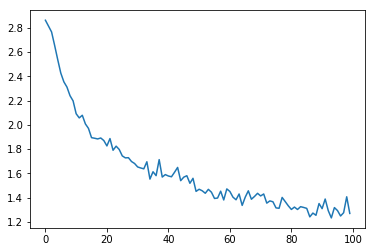

In [24]:
### Plotting the results
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

### Evaluating the model

#### Confusion matrix

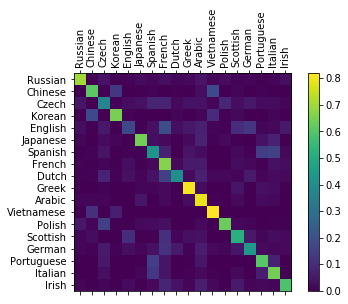

In [26]:
# keep track of correct/incorrect guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output


for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### Running on User Input

In [33]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Isabelle')
predict('Benoit')
predict('Olivier')


> Isabelle
(-0.68) French
(-2.03) Spanish
(-2.17) Greek

> Benoit
(-0.85) French
(-1.94) Czech
(-2.56) German

> Olivier
(-0.77) French
(-2.32) Russian
(-2.32) Czech
